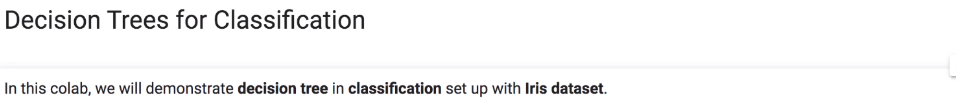

In [6]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import r2_score

# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import ShuffleSplit
# from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

# from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [3]:
features, labels = load_iris(return_X_y=True, as_frame=True)

In [4]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

In [7]:
dt_pipeline = Pipeline([
    ('feature_scaling', MinMaxScaler()),
    ('dt_classifier', DecisionTreeClassifier(max_depth=3, random_state=42)),
])

In [8]:
dt_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', MinMaxScaler()),
                ('dt_classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

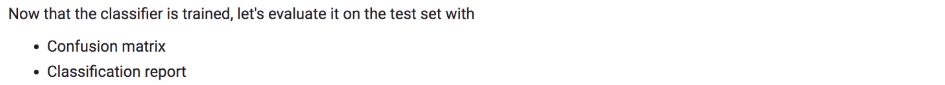

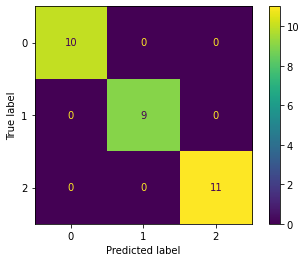

In [9]:
ConfusionMatrixDisplay.from_estimator(dt_pipeline, test_features, test_labels)

In [10]:
print(classification_report(test_labels, dt_pipeline.predict(test_features)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [11]:
data = load_iris()

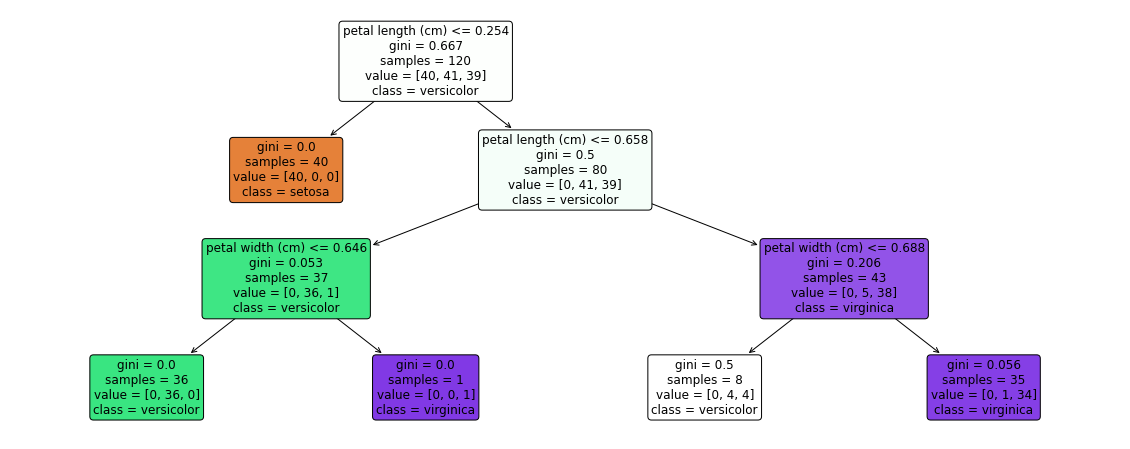

In [12]:
plt.figure(figsize=(20,8), facecolor='w')

a = tree.plot_tree(
    dt_pipeline[-1],
    feature_names=features.columns,
    class_names=data.target_names,
    rounded=True,
    filled=True,
    fontsize=12
)
plt.show()

In [14]:
# export the decision rules
tree_rules = export_text(dt_pipeline[-1], feature_names=list(features.columns))
print(tree_rules)

|--- petal length (cm) <= 0.25
|   |--- class: 0
|--- petal length (cm) >  0.25
|   |--- petal length (cm) <= 0.66
|   |   |--- petal width (cm) <= 0.65
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.65
|   |   |   |--- class: 2
|   |--- petal length (cm) >  0.66
|   |   |--- petal width (cm) <= 0.69
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.69
|   |   |   |--- class: 2



In [15]:
# extract importance
importance = pd.DataFrame({
    'feature': features.columns,
    'importance': np.round(dt_pipeline[-1].feature_importances_, 3)
})

importance.sort_values('importance', ascending=False, inplace=True)
print(importance)

             feature  importance
2  petal length (cm)       0.935
3   petal width (cm)       0.065
0  sepal length (cm)       0.000
1   sepal width (cm)       0.000


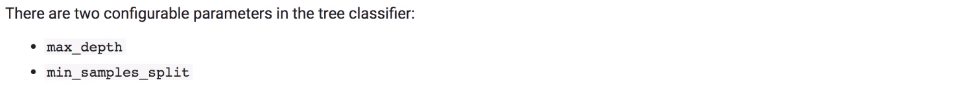

In [19]:
hp_grid = [{
    'dt_classifier__max_depth': [1, 2, 3, 4, 5],
    'dt_classifier__min_samples_split': [2, 4, 6, 8, 10]
}]
gs_clf = GridSearchCV(dt_pipeline, hp_grid, scoring='f1_macro')
gs_clf.fit(train_features, train_labels)

print('Best parameters:')
print(gs_clf.best_params_)
print()
print('Grid scores:')
means = gs_clf.cv_results_['mean_test_score']
stds = gs_clf.cv_results_['std_test_score']    
for mean, std, params in zip(means, stds, gs_clf.cv_results_['params']):
    print(f'{mean:0.3f} (+/-{std*2:0.03f}) for {params}')

Best parameters:
{'dt_classifier__max_depth': 4, 'dt_classifier__min_samples_split': 2}

Grid scores:
0.559 (+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 2}
0.559 (+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 4}
0.559 (+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 6}
0.559 (+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 8}
0.559 (+/-0.014) for {'dt_classifier__max_depth': 1, 'dt_classifier__min_samples_split': 10}
0.916 (+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 2}
0.916 (+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 4}
0.916 (+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 6}
0.916 (+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__min_samples_split': 8}
0.916 (+/-0.091) for {'dt_classifier__max_depth': 2, 'dt_classifier__

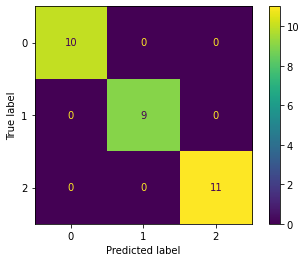

In [20]:
ConfusionMatrixDisplay.from_estimator(gs_clf.best_estimator_, test_features, test_labels)